[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [19]:
import os

os.environ["ROBOFLOW_API_KEY"] = input("Enter your Roboflow API Key: ")
os.system(f'export ROBOFLOW_API_KEY={os.environ["ROBOFLOW_API_KEY"]}')
print("API Key 已儲存到環境變數")


API Key 已儲存到環境變數


In [ ]:
api_key = os.environ.get("ROBOFLOW_API_KEY")
print(f"ROBOFLOW_API_KEY: {api_key}")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Sat Jul 26 13:21:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:18:00.0 Off |                  Off |
| 30%   36C    P8              25W / 300W |  47192MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
import os

os.chdir('/data/mycode/code/Yolo_OOB_image_detection')
HOME = os.getcwd()
print(HOME)

/data/mycode/code/Yolo_OOB_image_detection


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [7]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [8]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-07-26 13:38:14--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K   450KB/s    in 0.2s    

2025-07-26 13:38:15 (450 KB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|███████████████████████████████████████████████████████████████████████████████| 51.4M/51.4M [00:05<00:00, 9.10MB/s]


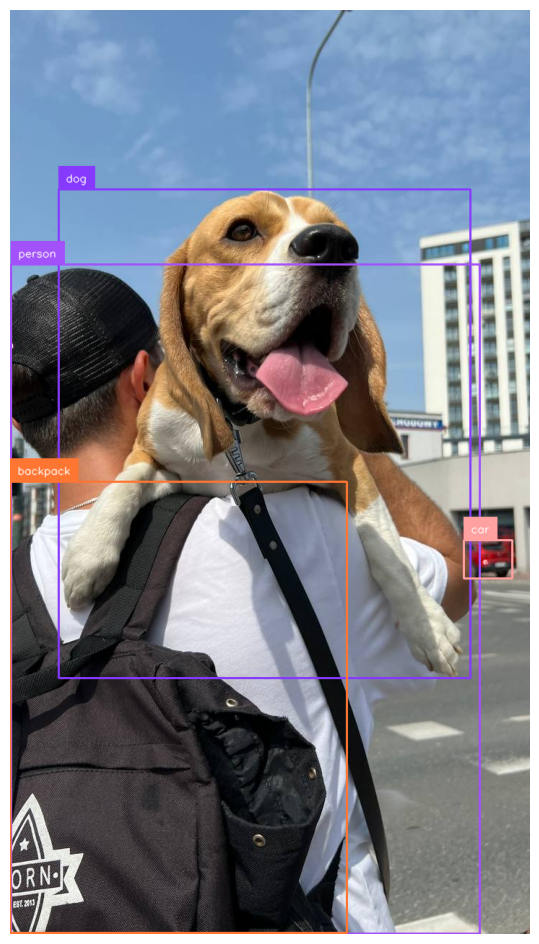

In [9]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [50]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("fcu109").project("ic-7za0g-gfb6e")
version = project.version(1)
dataset = version.download("yolov12")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to IC-1 in yolov12:: 100%|██████████████████████████| 3852/3852 [00:00<00:00, 7597.17it/s]


In [49]:
!pwd

/data/mycode/code/Yolo_OOB_image_detection


In [36]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [37]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [38]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 8
names: ['center', 'donut', 'edge_loc', 'edge_ring', 'loc', 'near_full', 'normal', 'scratch']

-e test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100, imgsz=256, batch=16, device='0', project='yolov12_ic_defect_oob', name='train_yolov12_ic_defect_oob', exist_ok=True)

New https://pypi.org/project/ultralytics/8.3.169 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.0rc1 torch-2.5.1+cu118 CUDA:0 (NVIDIA RTX A6000, 48677MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/data/mycode/code/Yolo_OOB_image_detection/IC-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolov12_ic_defect_oob, name=train_yolov12_ic_defect_oob, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

train: Scanning /data/mycode/code/Yolo_OOB_image_detection/IC-1/train/labels.cache... 1680 images, 0 backgrounds, 0 corru
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /data/mycode/code/Yolo_OOB_image_detection/IC-1/valid/labels.cache... 160 images, 0 backgrounds, 0 corrupt:


Plotting labels to yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to yolov12_ic_defect_oob/train_yolov12_ic_defect_oob
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.04G      3.606      4.601      4.111         30        256: 100%|██████████| 105/105 [00:14<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:

                   all        160        160          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.956G      2.913      3.425      3.102         43        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:


                   all        160        160      0.209      0.051     0.0487     0.0134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         1G      1.931      2.349      2.199         35        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.783      0.445      0.536      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.03G      1.458      1.754      1.787         33        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.553       0.82      0.704      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         1G      1.267      1.477      1.604         33        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.688      0.823      0.846      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.977G      1.148      1.269      1.484         48        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.744      0.922      0.886      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.977G      1.102      1.157       1.43         37        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.916       0.82      0.844      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.973G      1.048      1.077      1.389         33        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.762      0.922      0.932      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.03G      1.025      1.037      1.369         32        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.891      0.845      0.919      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.977G     0.9714     0.9634       1.33         37        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.812       0.93      0.961      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.02G     0.9897     0.9584       1.33         33        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.94      0.849      0.969      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         1G     0.9558     0.9111      1.303         35        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.872      0.957      0.965       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.04G     0.9435     0.9019      1.294         35        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.913      0.924      0.959      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.03G     0.9169     0.8614      1.287         35        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.896      0.898      0.954      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.977G     0.8817     0.8166       1.26         41        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.909      0.945      0.973       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.973G     0.8875     0.8258      1.253         36        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.898      0.972      0.984      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.04G     0.8614     0.7903      1.241         30        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.933       0.98       0.99      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.03G     0.8629     0.8017      1.239         33        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.922      0.971      0.989      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.02G     0.8457     0.7665      1.225         33        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.902      0.974      0.978      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         1G     0.8447     0.7486      1.221         38        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.937      0.981      0.988      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.998G     0.8157     0.7268      1.204         38        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.896      0.968      0.976      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.994G     0.8305     0.7434      1.203         43        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.946      0.941      0.969      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.977G     0.8282     0.7215      1.206         36        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.919      0.955      0.971      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.973G     0.7814     0.7201      1.188         38        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.945      0.966       0.98      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.977G     0.8146      0.723      1.204         24        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.924      0.961      0.981      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         1G     0.7786     0.6808      1.181         28        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.891      0.947      0.965      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.02G     0.8148     0.7139      1.202         37        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.938      0.984      0.985      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         1G     0.7996      0.685      1.187         37        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.938      0.996      0.991      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.03G     0.7871     0.6761      1.183         38        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.96      0.961      0.975      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.03G     0.7648     0.6526      1.162         35        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.96      0.956       0.97      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.02G     0.7775     0.6613       1.17         36        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.947      0.973      0.979       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         1G     0.7485     0.6492      1.163         34        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.943      0.993      0.981      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.998G     0.7592     0.6413      1.161         31        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.953      0.957      0.979      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.994G     0.7509     0.6278      1.159         32        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.962       0.97      0.984      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.01G     0.7499     0.6205      1.153         34        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.931       0.98      0.976      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.994G     0.7456     0.6395      1.151         30        256: 100%|██████████| 105/105 [00:11<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.951      0.986      0.982       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.03G     0.7357     0.6191      1.142         34        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.944      0.963      0.975      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.994G     0.7237     0.6305      1.133         37        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.942          1      0.993      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.977G     0.7289     0.6074      1.142         36        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.949      0.985      0.972      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.973G     0.7349     0.6118      1.141         38        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.964      0.982       0.98      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.03G     0.7265     0.6076      1.145         33        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.964      0.981      0.981      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.977G     0.7013     0.5934      1.121         34        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.944      0.981       0.98      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.02G     0.7136     0.6012      1.135         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.94      0.985      0.978      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         1G     0.7042      0.579      1.126         35        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.952      0.972      0.978      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.04G     0.6964     0.5834      1.128         42        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.939      0.985      0.983       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.03G     0.6825     0.5742       1.12         33        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.956       0.99      0.987      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.977G     0.6882     0.5729      1.118         32        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.97      0.964      0.985      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.973G     0.6852     0.5709      1.125         36        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.958      0.987      0.985      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.04G     0.7011     0.5869      1.121         37        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.952      0.978      0.984      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         1G     0.6856     0.5669      1.118         41        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.915      0.986      0.977      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.977G     0.6892     0.5553       1.11         38        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.958      0.982      0.993      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.973G     0.6571     0.5423      1.095         35        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.974      0.984      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.977G     0.6792     0.5631      1.111         38        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.946       0.98       0.98      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         1G     0.6669     0.5528      1.103         36        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.959      0.999      0.989      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.977G     0.6543     0.5478      1.101         41        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.958      0.993      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.973G      0.668     0.5418      1.101         30        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.95      0.987      0.987      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.977G     0.6578     0.5393      1.103         35        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.961      0.977      0.986      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         1G     0.6586      0.536      1.099         32        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.973      0.971      0.981       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.977G     0.6617     0.5433      1.095         33        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.953      0.993      0.982       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.973G     0.6523     0.5318      1.103         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.96      0.987      0.985      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.977G     0.6488     0.5272      1.088         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.967      0.966      0.976      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         1G     0.6565     0.5253      1.095         30        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.942      0.996      0.979      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.977G      0.661     0.5521      1.099         32        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.957      0.993      0.986      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.973G     0.6352     0.5241      1.083         38        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.978       0.99       0.99      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.977G     0.6055     0.5057      1.072         42        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.964      0.986      0.983       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         1G     0.6484     0.5252      1.087         41        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.968      0.993      0.981      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.977G     0.6403      0.525      1.094         28        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.971      0.992      0.983      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.973G     0.6204     0.5126      1.083         36        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.966      0.988      0.987      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.977G     0.6461     0.5241      1.098         37        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.956      0.991       0.99      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         1G     0.6179     0.5124      1.074         46        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.964      0.987      0.983      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.977G       0.63     0.5012      1.083         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.973       0.99      0.986       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.973G     0.6165     0.5056      1.081         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.97      0.993      0.985      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.977G     0.6008     0.5038      1.063         41        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.975       0.98      0.986      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         1G     0.5992     0.4969      1.069         42        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.971       0.99      0.986      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.977G     0.6281     0.5111      1.079         40        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.976      0.986      0.986      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.973G     0.6221     0.5143      1.077         37        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.983      0.977      0.987       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.977G     0.5918     0.4879      1.065         35        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.975       0.98      0.986      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         1G     0.5988     0.4976       1.07         36        256: 100%|██████████| 105/105 [00:14<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.981      0.984       0.99      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.977G     0.5919     0.4825      1.066         38        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.977       0.98      0.988      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.973G     0.5928     0.4668      1.064         33        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.971      0.991      0.987      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.977G     0.6063      0.492      1.072         44        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.962      0.993      0.987      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         1G     0.5908     0.4809      1.069         35        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.972      0.993      0.989       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.977G     0.5993     0.4767       1.07         40        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.967      0.993      0.989      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.973G     0.5966     0.4869      1.066         36        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.972      0.993      0.985      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.977G     0.5806     0.4757      1.058         31        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.976      0.991       0.99      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         1G     0.5672     0.4615      1.049         38        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.974      0.996      0.991      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.977G     0.5915     0.4773      1.058         42        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.973      0.985      0.988      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.973G     0.5777     0.4735      1.053         39        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.98      0.997      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.977G     0.5622     0.4658      1.049         32        256: 100%|██████████| 105/105 [00:13<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.975      0.983       0.99       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         1G     0.5878     0.4752      1.062         46        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.983       0.98      0.986      0.784


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.977G     0.5528     0.3634      1.038         16        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.975      0.987      0.989      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.973G     0.5393     0.3479       1.02         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.972      0.993       0.99      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.977G     0.5313     0.3372      1.029         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.981      0.991      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         1G     0.5236     0.3377      1.024         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.986          1      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.977G     0.5137     0.3371      1.019         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.978      0.996      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.973G      0.513     0.3362      1.011         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.983       0.99       0.99      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.977G     0.5061      0.325      1.014         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.983      0.987      0.991      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         1G     0.5006     0.3218     0.9973         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160       0.98      0.987       0.99      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.977G     0.4944     0.3226      1.002         16        256: 100%|██████████| 105/105 [00:12<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.984      0.987       0.99      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.973G     0.4952     0.3209     0.9979         16        256: 100%|██████████| 105/105 [00:13<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:

                   all        160        160      0.983      0.988      0.991      0.781



100 epochs completed in 0.407 hours.
Optimizer stripped from yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/weights/last.pt, 18.6MB
Optimizer stripped from yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/weights/best.pt, 18.6MB

Validating yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.0rc1 torch-2.5.1+cu118 CUDA:0 (NVIDIA RTX A6000, 48677MiB)
YOLOv12s summary (fused): 376 layers, 9,077,304 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:


                   all        160        160      0.976      0.984      0.987      0.799
                center         16         16      0.984          1      0.995      0.452
                 donut         13         13      0.977          1      0.995       0.75
              edge_loc         19         19      0.943      0.871      0.929       0.66
             edge_ring         17         17      0.966          1      0.995      0.995
                   loc         21         21      0.988          1      0.995      0.748
             near_full         27         27      0.985          1      0.995      0.995
                normal         21         21       0.98          1      0.995      0.995
               scratch         26         26      0.986          1      0.995      0.794
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to yolov12_ic_defect_oob/train_yolov12_ic_defect_oob


## Evaluate fine-tuned YOLOv12 model

In [26]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/

F1_curve.png					      state_dict.pt
PR_curve.png					      train_batch0.jpg
P_curve.png					      train_batch1.jpg
R_curve.png					      train_batch2.jpg
args.yaml					      train_batch9450.jpg
confusion_matrix.png				      train_batch9451.jpg
confusion_matrix_normalized.png			      train_batch9452.jpg
events.out.tfevents.1753508604.35b6ea230c57.97630.1   val_batch0_labels.jpg
events.out.tfevents.1753508731.35b6ea230c57.100903.0  val_batch0_pred.jpg
labels.jpg					      val_batch1_labels.jpg
labels_correlogram.jpg				      val_batch1_pred.jpg
model_artifacts.json				      val_batch2_labels.jpg
results.csv					      val_batch2_pred.jpg
results.png					      weights
roboflow_deploy.zip


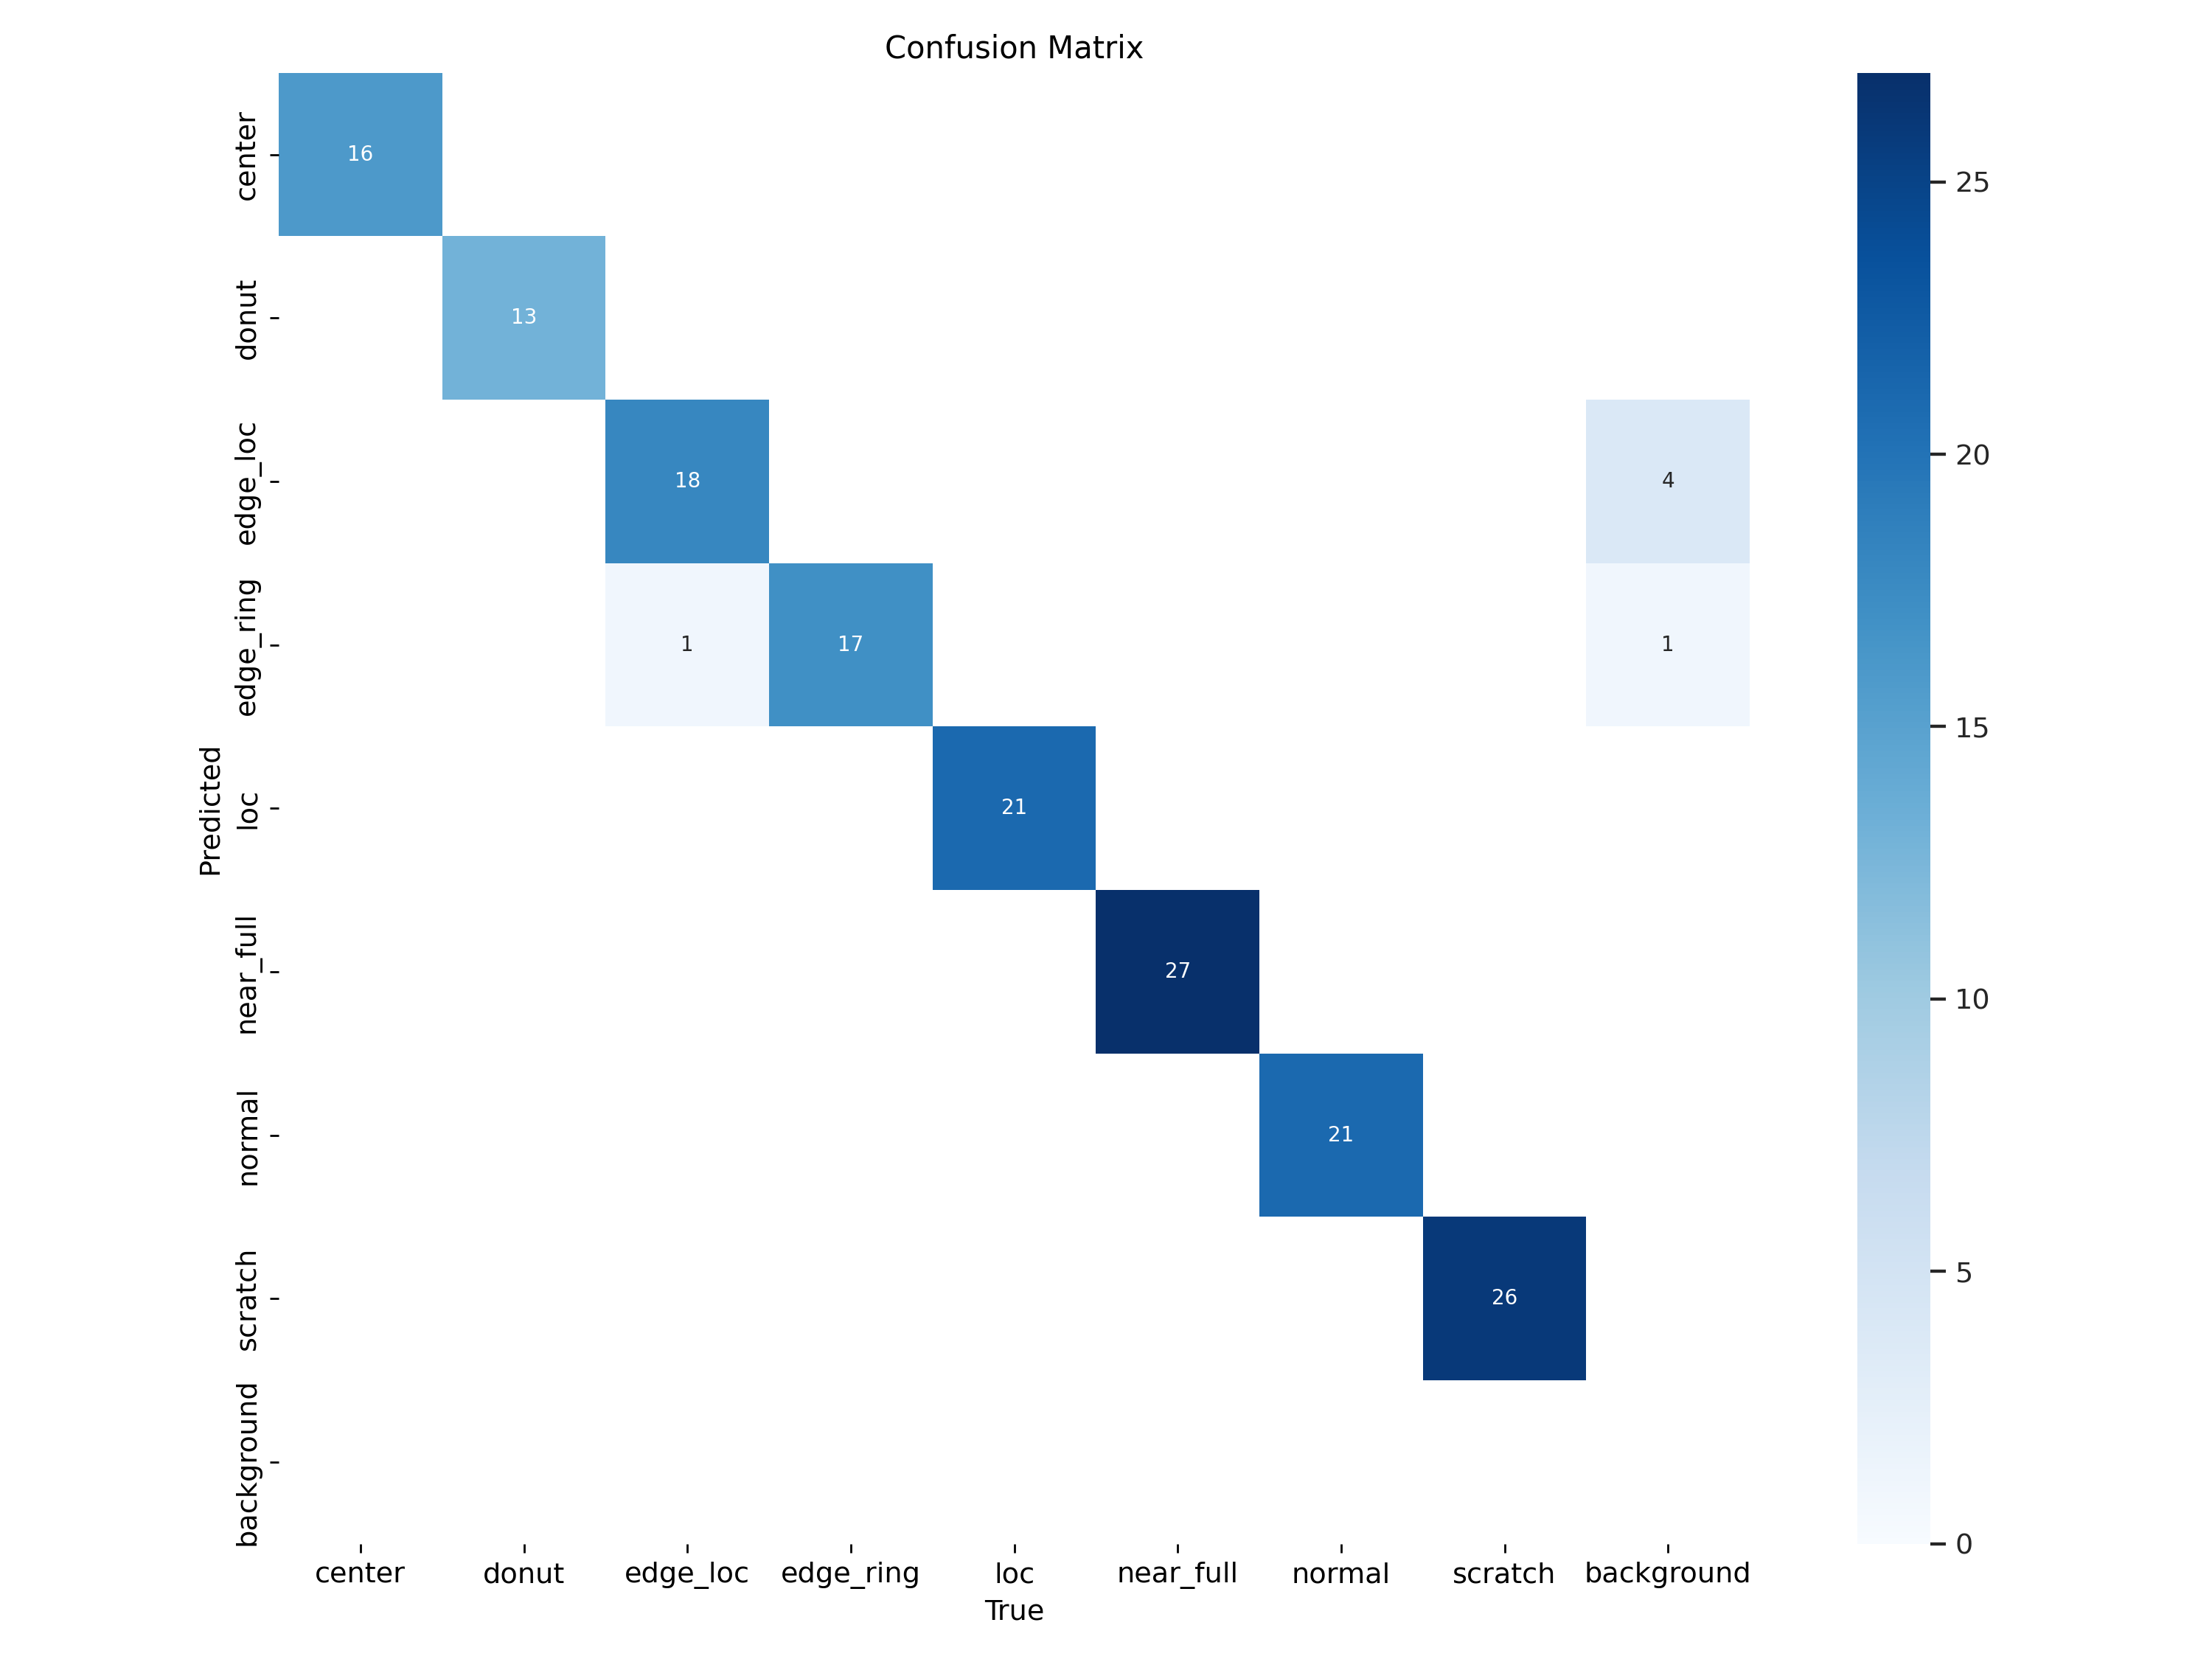

In [39]:
from IPython.display import Image

Image(filename=f'{HOME}/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/confusion_matrix.png', width=1000)

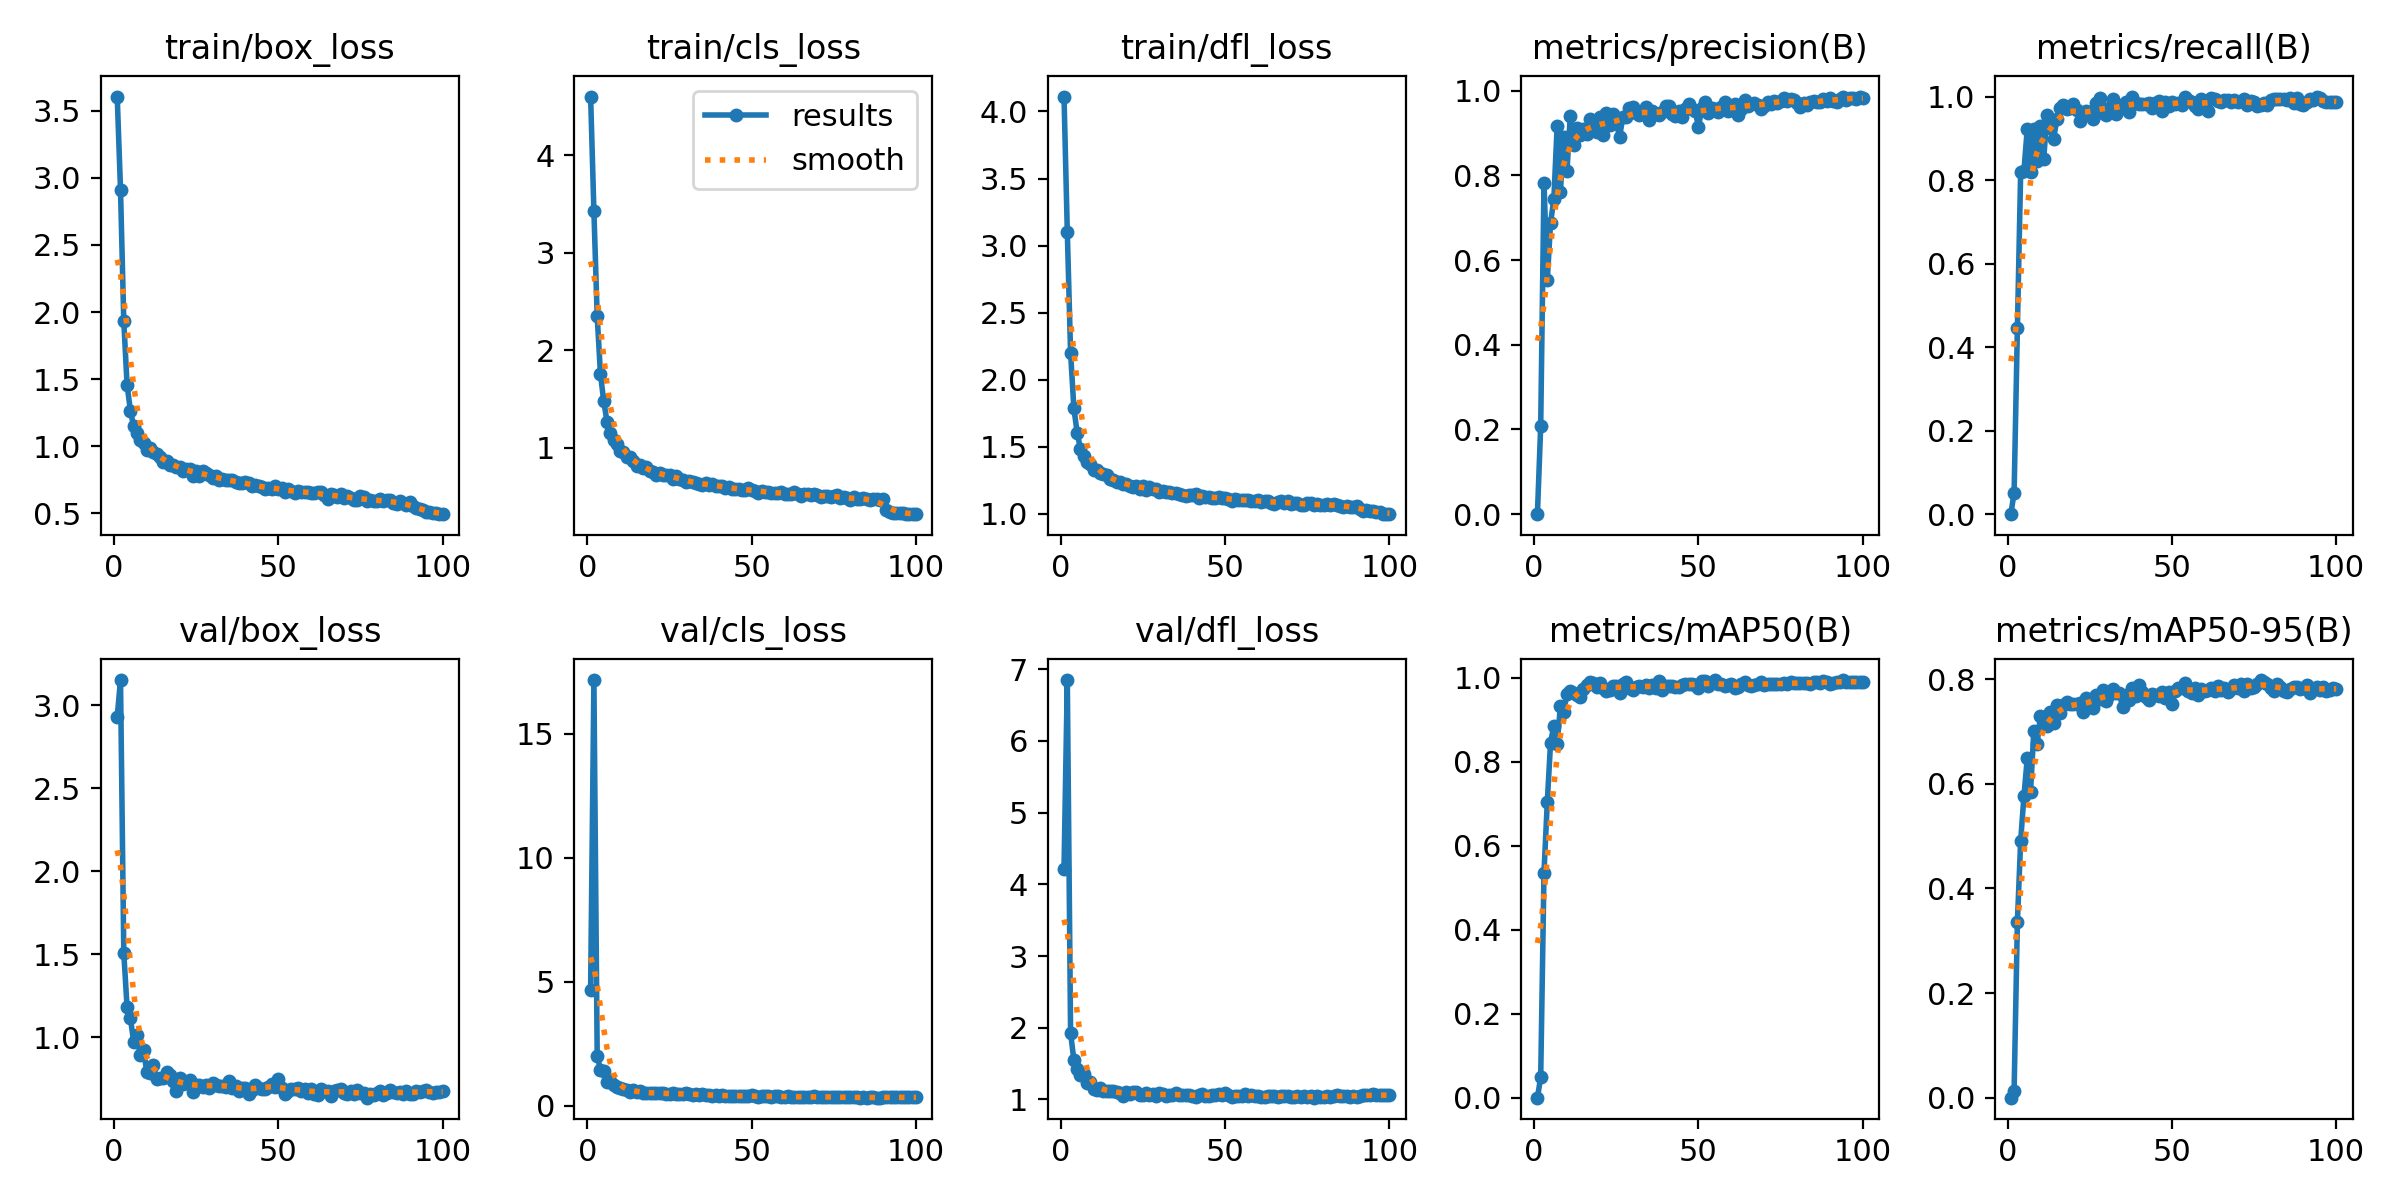

In [40]:
from IPython.display import Image

Image(filename=f'{HOME}/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/results.png', width=1000)

In [41]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['center',
 'donut',
 'edge_loc',
 'edge_ring',
 'loc',
 'near_full',
 'normal',
 'scratch']

In [42]:
from supervision.metrics import MeanAveragePrecision
from ultralytics import YOLO
model = YOLO(f'/{HOME}/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [43]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7968054573314474
mAP 50 0.9811115040075435
mAP 75 0.8597241867043847


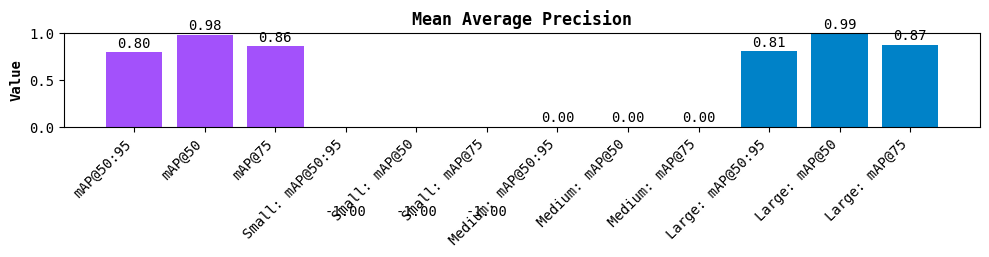

None

In [ ]:
x=map.plot()

## Run inference with fine-tuned YOLOv12 model

In [45]:
import supervision as sv

model = YOLO(f'/{HOME}/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

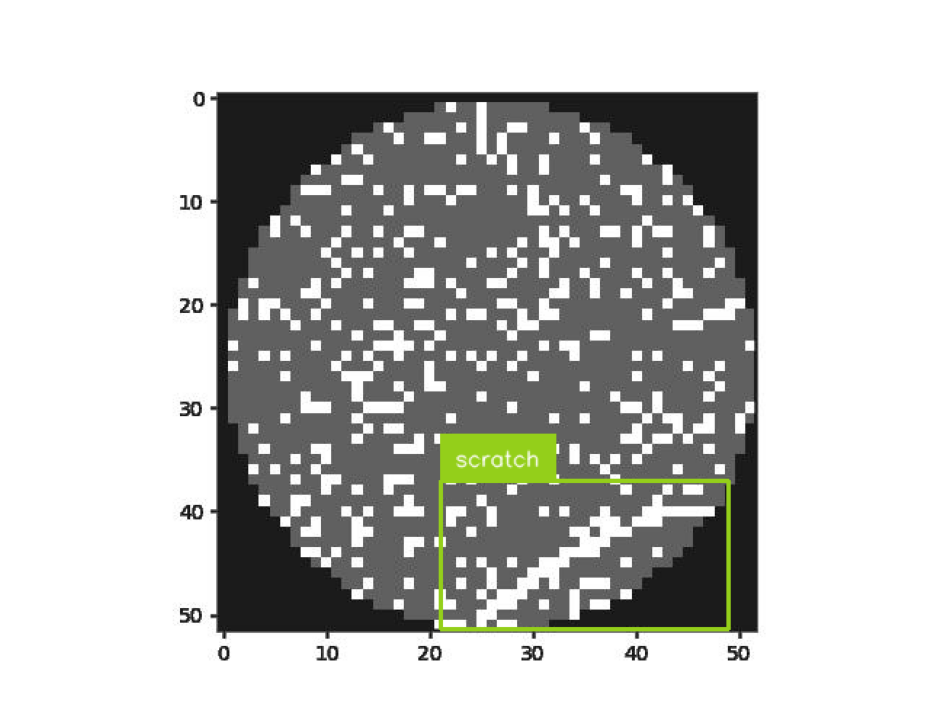

In [46]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
workspace=rf.workspace("fcu109")
workspace.deploy_model(
    model_type="yolov12",  # Type of the model
    model_path="/data/mycode/code/Yolo_OOB_image_detection/yolov12_ic_defect_oob/train_yolov12_ic_defect_oob/",  # Path to model directory
    project_ids=["ic-7za0g-gfb6e"],  # List of project IDs
    model_name="my-IC-model",  # Name for the model (must have at least 1 letter, and accept numbers and dashes)
    filename="weights/best.pt"  # Path to weights file (default)
)

loading Roboflow workspace...



!!! ATTENTION !!!
Model must be trained and uploaded using ultralytics from https://github.com/sunsmarterjie/yolov12
or through the Roboflow platform
!!! ATTENTION !!!

View the status of your deployment for project ic-7za0g-gfb6e at: https://app.roboflow.com/fcu109/ic-7za0g-gfb6e/models
